# The Great Divide: A/B Testing and Hypothesis Test

[**Analysis 참고 레퍼런스**](https://www.kaggle.com/code/phchen5/the-great-divide-a-b-testing-and-hypothesis-test/notebook)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
import warnings
# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

# Dataset : Mobile Game

- userid - the userid is just the user id. Each unique id represents a unique player. Nothing special here.
- version - version takes on two values: gate_30 and gate_40. When users are playing this game, they encounter gates that force them to wait a while before they can progress. gate_30 and gate_40 just means that the gate is placed at level 30 and level 40, respectively. version is also our group of interest. We want to perform A/B testing to determine whether placing the gate at these two different levels would impact player retention and game rounds.
- sum_gamerounds - the number of game rounds played by the user in the first week of installation
- retention_1 (bool) - whether the user came back to play the game 1 day after installation
- retention_7 (bool) - whether the user came back to play the game 7 days after installation

-> 레벨 30과 레벨 40에 게이트를 배치하는 것이 리텐션과 게임 라운드에 어떤 영향을 미치는지 확인

In [3]:
data = pd.read_csv('/Users/gwangyongkim/Documents/Python/AB test(ex)/cookie_cats.csv')
data.sample(5)

,userid,version,sum_gamerounds,retention_1,retention_7
7258,803963,gate_40,3,False,False
85992,9524767,gate_30,9,False,False
31528,3508809,gate_40,93,True,False
48363,5362272,gate_40,9,False,False
58289,6454300,gate_30,76,True,False


In [4]:
data.shape

(90189, 5)

### Exploratory Data Analysis (EDA)

Now let's take a deeper dive into our dataset by constructing some data visualizations. We'll start with the distribution for version, our group of interest.

<Axes: xlabel='version', ylabel='count'>

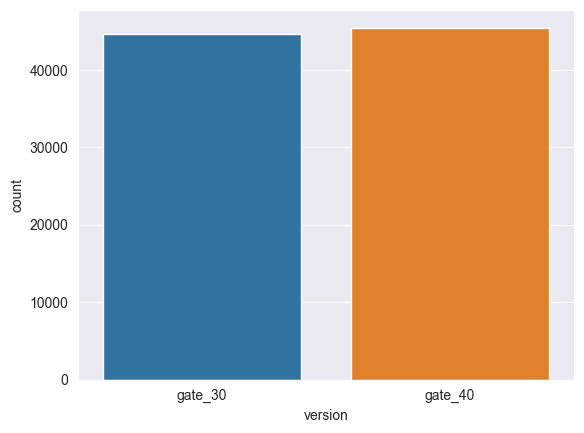

In [5]:
sns.countplot(data=data, x="version")

In [6]:
data.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


- 두 값의 갯수가 거의 45,000 수준으로 거의 동일

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

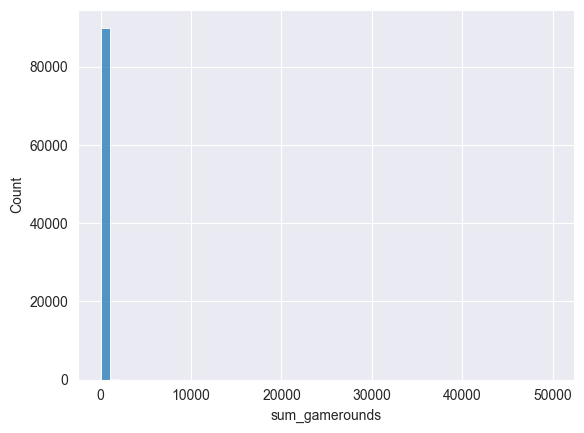

In [7]:
sns.histplot(data=data, x="sum_gamerounds", bins=50)

히스토그램 오른쪽의 값이 없는 것 처럼 보이지만, 실제로는 값이 있기 때문에 박스플롯으로 재확인

<Axes: xlabel='sum_gamerounds'>

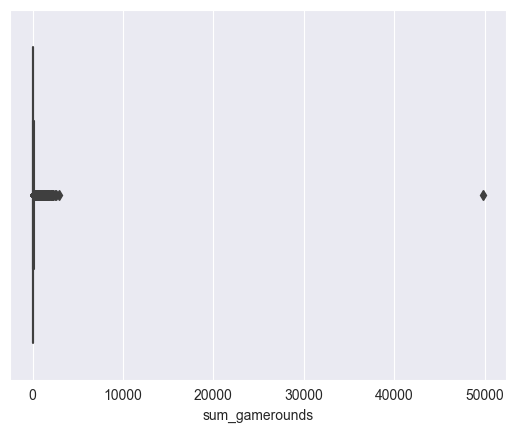

In [8]:
sns.boxplot(data=data, x="sum_gamerounds")

### 이상치(Outlier)

installation 이후 1주일 만에 거의 50,000 라운드에 가까운 게임을 플레이한 극단적인 이상값(Outlier)을 가진 플레이어가 한 명 존재
- 실제로 플레이를 50,000 라운드 가까이 했거나, 버그나 데이터 오류일 가능성

-> 이상치 제거가 필요

### 이상치 제거

In [9]:
data = data.drop(data[data.sum_gamerounds > 40000].index)

<Axes: xlabel='sum_gamerounds'>

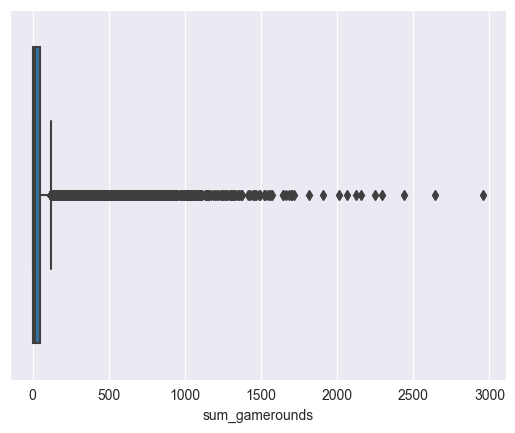

In [10]:
sns.boxplot(data=data, x="sum_gamerounds")

리텐션 데이터 확인

<Axes: xlabel='retention_1', ylabel='count'>

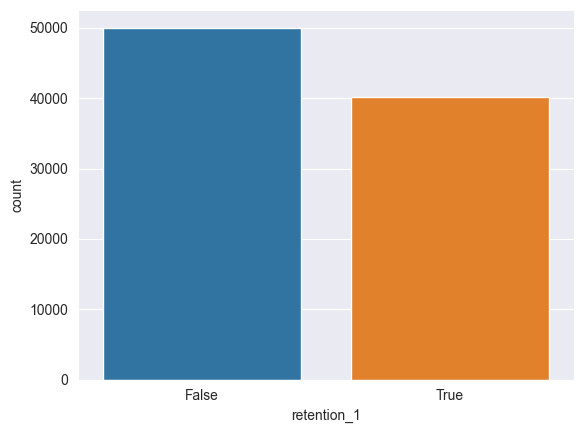

In [11]:
sns.countplot(data=data, x="retention_1")

<Axes: xlabel='retention_7', ylabel='count'>

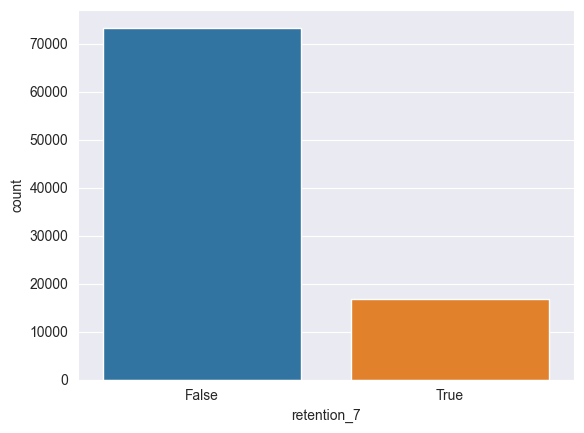

In [12]:
sns.countplot(data=data, x="retention_7")

<Axes: xlabel='sum_gamerounds', ylabel='version'>

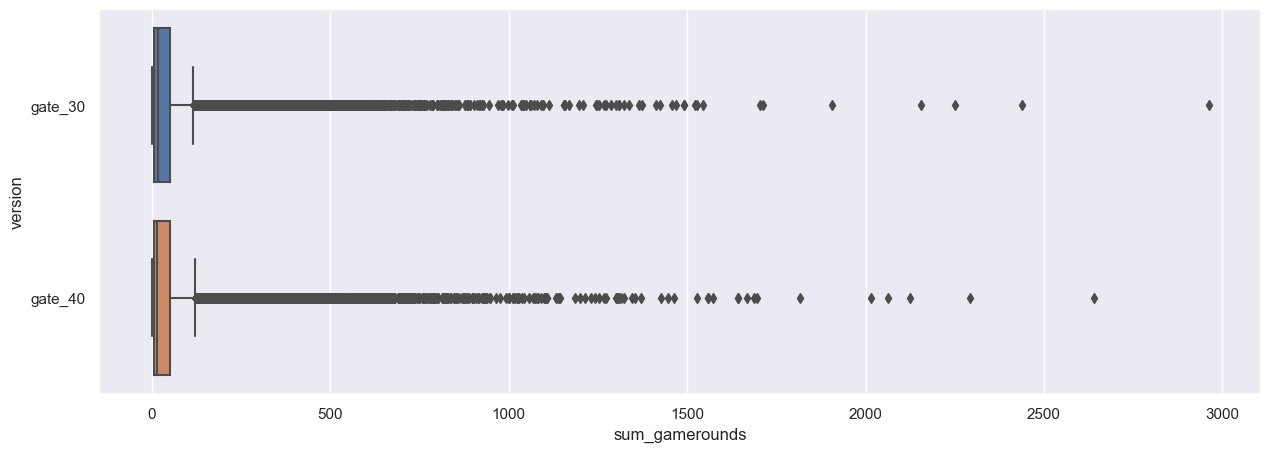

In [13]:
# version 별 sum_gamegrounds 데이터 분포 확인
sns.set(rc={'figure.figsize':(15, 5)})
#plot boxplot
sns.boxplot(data=data, x="sum_gamerounds", y="version")

sum_gamegrounds에 대한 조금 더 구체적인 통계 데이터 확인

In [14]:
data.sum_gamerounds.describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

평균(mean)이 51.32 이므로, 게임 라운드가 적은 유저에 대해 히스토그램 확인

(0.0, 30.0)

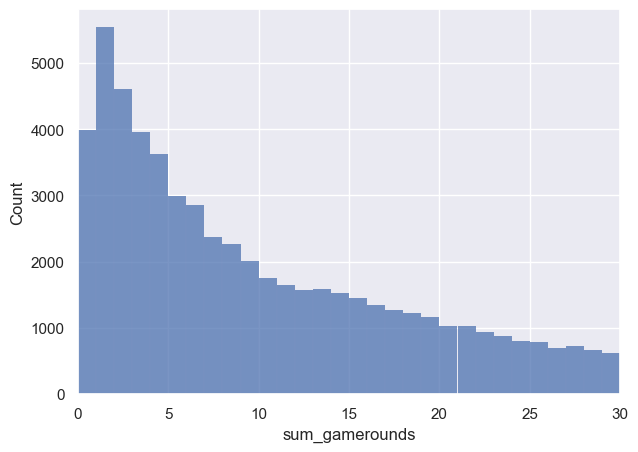

In [15]:
sns.set(rc={'figure.figsize':(7, 5)})
#plot histogram
sns.histplot(data["sum_gamerounds"], bins=2961)
#limit x-axis to range (0, 200)
plt.xlim(0, 30)

installation 이후 첫 주에 1번만 플레이하는 경우가 가장 많고, 한 번도 플레이하지 않는 경우도 많은 숫자로 나타남
- 이를 해결하기 위한 다음 과제로 선정

다음으로, version별 retention 지표 확인

<Axes: xlabel='retention_1', ylabel='count'>

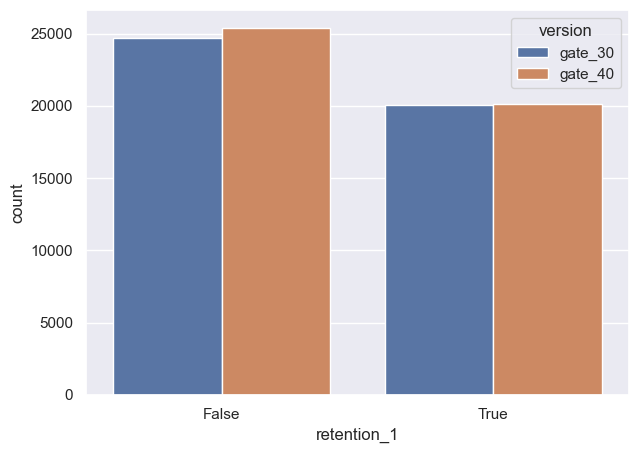

In [16]:
sns.countplot(data=data, x="retention_1", hue="version")

<Axes: xlabel='retention_7', ylabel='count'>

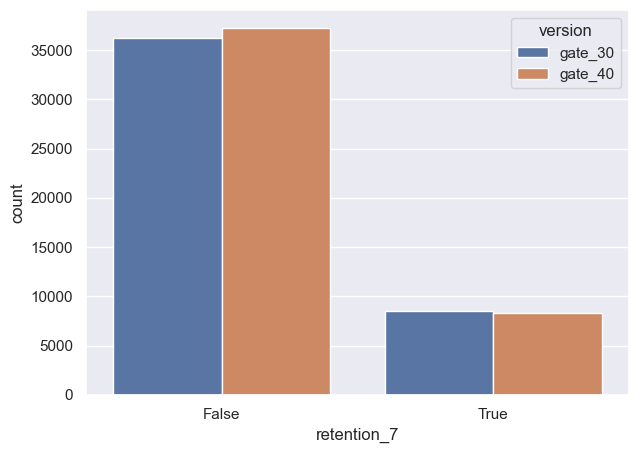

In [17]:
sns.countplot(data=data, x="retention_7", hue="version")

두 version 모두 d1, d7에서 크게 봤을 때 큰 차이를 보이지는 않는것 같이 보임
하지만, gate_40의 경우 gate_30보다 샘플 수가 많다는 것을 고려했을 때 d7의 카운트 플롯에서 False의 경우 gate_40이 더 높지만, True의 경우 gate_40은 더 낮은 것으로 보임

- d1의 경우 d7에 비해 큰 차이를 보이지 않음
- gate_40의 d7이 gate_30보다 낮은 것으로 보임
- 여기에서 차이를 식별할 수 있고, 이에 대한 테스트를 수행

# 가설 검증 (Hypothesis Testing)

- test 그룹별로 분리

In [18]:
#seperate control and treatment group
control = data[data["version"]=="gate_30"]
treatment = data[data["version"]=="gate_40"]

## 분산의 동질성 및 정규성 확인

### 분산 동질성 테스트

분산의 동질성 테스트를 위해 Levene의 분산 동질성 테스트 사용
- stats.levene()

**1. sum_gamerounds의 분산 동질성 확인**

In [19]:
stats.levene(control['sum_gamerounds'], treatment['sum_gamerounds'])

LeveneResult(statistic=0.07510153837481241, pvalue=0.7840494387892463)

p-value가 0.05 보다 크기 때문에 "각 그룹의 모집단에서의 분산이 동일하다"는 귀무가설을 기각하지 못함
- 따라서, 주어진 데이터에서는 등분산성을 가정할 수 "있음"
- 각 그룹의 모집단에서의 분산이 크게 다르지 않다는 것을 의미함
- t-test를 신뢰할 수 있는 분산의 동질성을 보여주는 것으로 해석

*-> 결론적으로 분산 동질성 테스트 결과가 유의하지 않기 때문에(p-value가 0.05보다 큼), 분산의 동질성이 있고 t-test를 진행할 수 있음*

**2. retention_1 및 retention_7의 분산 동질성 확인**

In [20]:
stats.levene(control['retention_1'], treatment['retention_1'])

LeveneResult(statistic=3.1937812288101903, pvalue=0.07392220630215537)

In [21]:
stats.levene(control['retention_7'], treatment['retention_7'])

LeveneResult(statistic=9.970119454790488, pvalue=0.0015915357297900119)

retention_1의 경우 p-value가 0.05를 초과하기 때문에 t-test를 신뢰할 수 있는 분산 동질성을 보여주지만, retention_7의 경우 p-value가 0.0015로 0.05보다 작기 때문에 분산의 동질성을 보여주지 못하는 것으로 해석됨

- 하지만, 통계 분석 예시를 위해 retention_7이 유의하지 못한 것을 감안해 가설 검증을 계속 진행함

### 분산 정규성 테스트

In [22]:
#distributions for sum_gamerounds
gamerounds_control = control["sum_gamerounds"]
gamerounds_treatment = treatment["sum_gamerounds"]

**1. Shapiro-Wilk Test**
- 귀무가설은 데이터가 정규 분포를 따른다는 것이고, p-value가 0.05 유의수준을 사용하면 control 그룹과 treatment 그룹 분포 모두에 대해 귀무 가설을 기각하고 정규분포를 따르지 않는 다는 결론을 내릴 수 있음

In [23]:
#compute test statistics and p-value for our two distributions to check for normality
control_shapiro_stat, control_shapiro_p = stats.shapiro(gamerounds_control)
treatment_shapiro_stat, treatment_shapiro_p = stats.shapiro(gamerounds_treatment)

#control group results
print("Shapiro-Wilk test statistic for control group: ", control_shapiro_stat)
print("P-value for control group: ", control_shapiro_p)
if control_shapiro_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (control group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) ")
    
#treatment group results
print("\nShapiro-Wilk test statistic for treatement group: ", treatment_shapiro_stat)
print("P-value for treatment group: ", treatment_shapiro_p)
if treatment_shapiro_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (treatment group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) ")

Shapiro-Wilk test statistic for control group:  0.48864299058914185
P-value for control group:  0.0
There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) 

Shapiro-Wilk test statistic for treatement group:  0.4825664758682251
P-value for treatment group:  0.0
There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) 


- W값이 0~1 사이의 값을 가지고, 귀무가설이 참이면 이론적으로 1이 나오도록 설계
- W값이 0에 가까우면 가까울수록 정규분포와는 다르게 분포되어있다고 봄
- p-value 가 0.05보다 작은 경우 귀무가설을 기각

control, treatment 두 그룹 모두 W값이 1보다는 0에 더 가깝고, p-value가 0.05 보다 작기 때문에 정규성을 따른다는 귀무가설을 기각함
- *즉, 두 그룹 모두 정규 분포를 따르지 않음*

**2. Kolmogorov–Smirnov test (a.k.a KS test)**
- 비교하고자 하는 두 분포의 empirical distribution function 의 차이를 특정 기준과 비교하여 기각의 여부를 결정

In [25]:
#compute test statistics and p-value for our two distributions to check for normality
control_kstest_stat, control_kstest_p = stats.kstest(gamerounds_control, "norm")
treatment_kstest_stat, treatment_kstest_p = stats.kstest(gamerounds_treatment, "norm")

#control group results
print("KS test statistic for control group: ", control_kstest_stat)
print("P-value for control group: ", control_kstest_p)
if control_kstest_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (control group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) ")

#treatment group results
print("\nKS test statistic for treatement group: ", treatment_kstest_stat)
print("P-value for treatment group: ", treatment_kstest_p)
if treatment_kstest_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (treatment group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) ")

KS test statistic for control group:  0.8724153079945488
P-value for control group:  0.0
There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) 

KS test statistic for treatement group:  0.8707186187388001
P-value for treatment group:  0.0
There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) 


- *KS test에서도 두 분포가 모두 정규분포가 아닌 것으로 나타남*

**3. q-q plot 을 통한 정규성 파악**
- 정규성을 시각적으로 확인하는 용도로 사용
- 빨간색 선을 기준으로 멀리 떨어져있는 데이터 포인트가 있다면 정상에서 벗어난 편차가 있다는 뜻

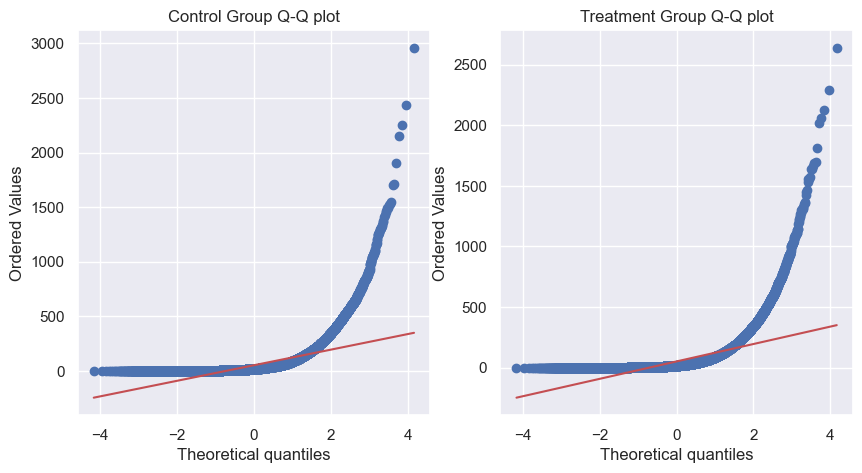

In [24]:
sns.set(rc={'figure.figsize':(10, 5)})
fig, ax = plt.subplots(1,2)

#Q-Q Plot
stats.probplot(gamerounds_control, plot=ax[0])
stats.probplot(gamerounds_treatment, plot=ax[1])
ax[0].set_title("Control Group Q-Q plot")
ax[1].set_title("Treatment Group Q-Q plot")
plt.show()

위에서 수행한 모든 테스트에서 두 분포가 정규성을 따르지 않는 것으로 확인됨

- **Next Step**
    - 정규성 조건이 충족되지 않는다면, 어떤 통계를 해야할까?
        - 분포에 대한 가정이 필요 없는 비모수 검정법을 사용
        - 여기에서는 분포가 왜곡된경우 평균보다 중심 경향을 더 잘 측정할 수 있는 두 중앙값(평균이 아님)을 비교하기 위해 Mann-Whitney U 테스트 진행

### Mann-Whitney U 테스트

- 두 샘플이 동일한 분포에서 나올 수 있다는 가설
    - 중심경향에도 유의미한 차이가 없어야 한다는 것을 의미

**1. sum_gamerounds 지표**

In [26]:
#perform the Mann-Whitney U test
mw_stat, mw_p = stats.mannwhitneyu(gamerounds_control, gamerounds_treatment)

#print the results
print('Mann-Whitney U statistic:', mw_stat)
print('P-value:', mw_p)

if mw_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two samples may come from the same distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (The two samples may come from different distributions)")

Mann-Whitney U statistic: 1024285761.5
P-value: 0.05089155279145376
There is not enough evidence to reject the null hypothesis (The two samples may come from the same distribution)


- 귀무가설을 기각할만한 유의미한 증거가 없다.
- 두 데이터 샘플은 동일한 분포에서 나온것이며 version 유형은 sum_gamerounds 값에 영향을 미치지 않는다고 결론을 낼 수 있다.
- 그러나 p-value가 0.05를 약간 상회한다는 것으로 보임
    - 따라서, 유의수준을 조금 더 높게 수정하면 결과가 유의미해질 수 있음

**p-value 0.05 유의수준에서 우리는 version의 gate_30과 gate_40의 sum_gamerounds 에 차이가 없다는 결론**

**2. retention_1 지표**

- Two-sample Z Test for proportions
    - 어떤 테스트를 수행할지 결정하는 데 있어 가장 중요한 규칙은 표본 크기를 살펴보는 것이다
    - 비율에 대한 Two-sample Z Test 에서는 표본 크기가 표본 분포에 대한 정규 근사를 얻을 만큼 충분히 크다고 가정함
    - 본 샘플에는 충분히 많은 샘플이 있기 때문에 문제가 없음
    - 비율에 대한 Two-sample Z Test를 수행하려면 성공 횟수와, 총 관찰 횟수 값을 가져와서 ratios_ztest 함수(statsmodel.stats.proportion)에 입력해야 한다.

In [27]:
#number of True values for retention_1 in control and treatment group
retention_1_successes = np.array([sum(control["retention_1"]), sum(treatment["retention_1"])])
#total number of observations in control and treatment group
retention_1_nobs = np.array([len(control["retention_1"]), len(treatment["retention_1"])])  

retention_1_successes, retention_1_nobs

(array([20034, 20119]), array([44699, 45489]))

In [28]:
#perform two-sample Z test for proportions
retention_1_stat, retention_1_p = proportions_ztest(count=retention_1_successes, nobs=retention_1_nobs)

#print the results
print("retention_1 Z test statistics two sample proportions:", retention_1_stat)
print("retention_1 p-value:", retention_1_p)

if retention_1_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

retention_1 Z test statistics two sample proportions: 1.787103509763628
retention_1 p-value: 0.0739207603418346
There is not enough evidence to reject the null hypothesis (The two proportions may be the same)


검정 결과, p-value 0.05 수준에서는 귀무가설을 기각하지 않으며, 두 비율에는 유의한 차이가 없는 것으로 나타남
- 이는 데이터 시각화 단계에서 초기 추측과도 일치함

### 카이제곱 독립성 검정(Chi-square Test of Independence)

다른 옵션인 카이제곱 독립성 검정은 두 범주형 변수간의 독립성을 테스트함
- 이 테스트는 비모수적 테스트이므로 데이터의 기본 분포에 대한 가정을 하지 않음
- 표본 크기가 작은 경우에는 비율에 대해 Two-sample Z Test 대신 카이제곱 검정을 사용하는 것이 더 적절할 수 있음
- 하지만 카이제곱 검정에도 나름의 가정이 있다는 것을 유의
    - 두 변수 모두 범주형
    - 관측값이 독립적
    - 관측값이 상호 베타적
    - 셀의 예상 값이 5보다 커야 함
    
-> 지금은 이 네 가지 가정이 모두 충족되고, 실제로 이 테스트를 수행할 수 있음

두 변수에 대한 관측된 확률 테이블을 구성한 다음 이를 scipy.stats의 chi2_contingency 함수에 입력
- 이 함수는 검정 통계, p-value, 자유도 및 예상되는 확률 테이블을 반환

In [29]:
#construct observed contingency table
retention_1_observed = np.array([[sum(control["retention_1"]), len(control["retention_1"])-sum(control["retention_1"])],
                                 [sum(treatment["retention_1"]), len(treatment["retention_1"])-sum(treatment["retention_1"])]])

retention_1_observed

array([[20034, 24665],
       [20119, 25370]])

In [30]:
#return test statistics, p-value, df and expected contingency table
retention_1_chi2_stat, retention_1_chi2_p, retention_1_dof, retention_1_expected = stats.chi2_contingency(retention_1_observed)

#print the results
print("Chi-square test statistics for retention_1: ", retention_1_chi2_stat)
print("P-value for retention_1: ", retention_1_chi2_p)
print("Degree of freedom: ", retention_1_dof)
print(retention_1_expected)

if retention_1_chi2_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

Chi-square test statistics for retention_1:  3.169835543170799
P-value for retention_1:  0.07500999897705693
Degree of freedom:  1
[[19900.64029583 24798.35970417]
 [20252.35970417 25236.64029583]]
There is not enough evidence to reject the null hypothesis (The two proportions may be the same)


- 카이제곱 검정 결과는 비율에 대한 Two-sample Z test와 일치함
#### 유의수준 0.05에서 귀무가설을 기각하지 못하므로 version과 retention_1 사이에는 관계가 없다는 것으로 결론

**3. retention_7 지표**

- Two-samle Z test 수행

In [31]:
retention_7_successes = np.array([sum(control["retention_7"]), sum(treatment["retention_7"])])
retention_7_nobs = np.array([len(control["retention_7"]), len(treatment["retention_7"])])  

retention_7_successes, retention_7_nobs

(array([8501, 8279]), array([44699, 45489]))

In [32]:
retention_7_stat, retention_7_p = proportions_ztest(count=retention_7_successes, nobs=retention_7_nobs)

print("retention_7 Z test statistics two sample proportions:", retention_7_stat)
print("retention_7 p-value:", retention_7_p)

if retention_7_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

retention_7 Z test statistics two sample proportions: 3.1574100858819936
retention_7 p-value: 0.0015917731773993442
There is enough evidence to reject the null hypothesis (The two proportions may be different)


- 카이제곱 검정(Chi-squared Test)

In [33]:
retention_7_observed = np.array([[sum(control["retention_7"]), len(control["retention_7"])-sum(control["retention_7"])],
                                 [sum(treatment["retention_7"]), len(treatment["retention_7"])-sum(treatment["retention_7"])]])

retention_7_observed

array([[ 8501, 36198],
       [ 8279, 37210]])

In [34]:
retention_7_chi2_stat, retention_7_chi2_p, retention_7_dof, retention_7_expected = stats.chi2_contingency(retention_7_observed)

print("Chi-square test statistics for retention_7: ", retention_7_chi2_stat)
print("P-value for retention_7: ", retention_7_chi2_p)
print("Degree of freedom: ", retention_7_dof)
print(retention_7_expected)

if retention_7_chi2_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

Chi-square test statistics for retention_7:  9.915275528905669
P-value for retention_7:  0.0016391259678654423
Degree of freedom:  1
[[ 8316.50796115 36382.49203885]
 [ 8463.49203885 37025.50796115]]
There is enough evidence to reject the null hypothesis (The two proportions may be different)


**두 테스트 모두 retention_7 비율에 차이가 있음을 나타냄**

## 결론

1. A/B test 결과 두 version(gate_30, gate_40)간의 차이는 미미한 것으로 나타남
    - gate_30과 gate_40의 차이는 플레이어가 각각 30레벨과 40레벨에서 강제로 일시정지한다는 것
    - 하지만, 초기 데이터 시각화를 통해 대부분의 플레이어가 게임을 몇 라운드만 플레이한 후 게임을 종료(시작조차 하지 않는경우도 있음)을 알게 되었음
    - **즉, 대부분의 플레이어가 30레벨에 도달하지도 않는 것으로 보임**
    - sum_gamerounds 및 retention_1(초기 게임 플레이를 측정하는)와 같은 변수에는 version 유형이 중요하지 않음
    
2. **반대로 retention_7에서는 두 version간에 차이가 있는 것으로 나타남**
   - 이 시점에서 대부분의 플레이어는 30레벨 또는 40레벨에 도달했을 가능성이 높ㅇ으므로 version 유형이 실제로 영향을 미칠 수 있을 것으로 보임
   - 이 현상에는 여러가지 설명이 있을 수 있지만, 확실한 것은 gate_30이 장기 플레이어 유지 측면에서 gate_40보다 더 나은 설명을 보이고 있음
   - 따라서, 서비스에서는 gate_40 보다는 gate_30을 채택해야 하고, 어쩌먄 gate_20 이나 gate_10 으로 숫자를 낮춰야 하는지 확인해볼 수도 있음